# 测试控制台

你知道吗？阳见惠凪太可爱了

## POD 构建

In [ ]:
from backend.pipeline import quick_build_pod

res = quick_build_pod(
    nc_path="data/cylinder2d.nc",
    r=128,
    center=True,
    var_keys=("u", "v"),
    verbose=True,   # 打印所有中间过程
    plot=True,      # 画出奇异值谱+累计能量图
)

print("实际使用的模态数 r_used =", res["r_used"])
print("前10阶累计能量:", res["cum_energy"][:10])


## 线性单帧 Demo

In [ ]:
from backend.pipeline import quick_test_linear_baseline

res = quick_test_linear_baseline(
    nc_path="data/cylinder2d.nc",
    pod_dir="artifacts/pod_r128",
    r=128,
    center=True,
    var_keys=("u", "v"),
    frame_idx=64,
    mask_rate=0.02,
    noise_sigma=0.01,
    max_modes=64,      # 前 64 个模态
    modes_per_fig=16,  # 每 16 个为一组：q1-16, q17-32, q33-48, q49-64
    channel=0,
    verbose=True,
)

print("POD 自身截断误差 NMSE =", res["nmse_pod"])
print("线性基线重建 NMSE      =", res["nmse_linear"])


## MLP 单帧 demo

In [ ]:
from backend.pipeline import quick_test_mlp_baseline

res = quick_test_mlp_baseline(
    nc_path="data/cylinder2d.nc",
    pod_dir="artifacts/pod_r128",
    r=128,
    center=True,
    var_keys=("u", "v"),
    frame_idx=64,
    mask_rate=0.02,
    noise_sigma=0.01,
    mlp_noise_sigma=0.01,
    batch_size=64,
    num_epochs=50,
    lr=1e-3,
    max_modes=64,
    modes_per_fig=16,
    channel=0,
    verbose=True,
)

print("NMSE(POD truncation) =", res["nmse_pod"])
print("NMSE(Linear baseline) =", res["nmse_linear"])
print("NMSE(MLP baseline)   =", res["nmse_mlp"])


## 完整 sweep + 多尺度分析

In [ ]:
from backend.pipeline import quick_full_experiment

result = quick_full_experiment(
    nc_path="data/cylinder2d.nc",
    var_keys=("u", "v"),
    r=128,
    center=True,
    mask_rates=[0.01, 0.02, 0.05, 0.10],
    noise_sigmas=[0.0, 0.01, 0.02],
    pod_bands={"L": (0, 16), "M": (16, 64), "H": (64, 128)},
    train_mask_rate=0.02,
    train_noise_sigma=0.01,
    max_epochs=50,
    device="cuda",
    verbose=True,
)

# 存盘 + 报告
from backend.eval.reports import save_full_experiment_results, generate_experiment_report_md

paths = save_full_experiment_results(result, "artifacts/experiments", "cylinder_exp1")
report_path = generate_experiment_report_md(result, "artifacts/experiments/cylinder_exp1/report.md",
                                            experiment_name="Cylinder-2D p-σ sweep")

result["df_linear"].head(), result["df_mlp"].head(), report_path


[yaml-experiment] Loading configs from configs/cylinder_exp1.yaml ...
[yaml-experiment] Running full evaluation (compute only) ...
=== [full-eval] compute_full_eval_results ===
[full-eval] Running linear baseline sweep ...
=== [eval-linear] Start linear baseline experiment ===
[eval] Found existing POD in artifacts/pod, skip rebuilding.
  - meta: T=1501, H=80, W=640, C=2, r_used=128, r_eff=128
[eval] Loaded eigenvalues from artifacts/pod/eigenvalues.npy, shape=(128,)
[eval] Loaded phi_groups from artifacts/pod/phi_groups.json, count=8
[eval] Loading full raw data from data/cylinder2d.nc ...
  -> X_thwc shape = (1501, 80, 640, 2), flatten = [1501, 102400], r_eff=128
  -> Projected all snapshots to POD space: A_true shape = (1501, 128)

[eval-linear] mask_rate = 0.0002
  -> total observed entries (with 2 channels) = 20
  [eval-linear] noise_sigma = 1.0000e-02
    -> NMSE(mean±std) = 1.1934e+00 ± 1.9282e-02, NMAE = 7.6590e-01, PSNR = 9.19 dB, effective_band=H3, r_cut=128
  [eval-linear] n

/home/wyr/projects/Ena/backend/pipeline.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 4, figsize=(12, 3))


[yaml-experiment] Saving figures under artifacts/experiments/cylinder_exp1_3 ...
[yaml-extract] Saved figure: artifacts/experiments/cylinder_exp1_3/nmse_vs_mask_linear.png
[yaml-extract] Saved figure: artifacts/experiments/cylinder_exp1_3/nmse_vs_mask_mlp.png
[yaml-extract] Saved figure: artifacts/experiments/cylinder_exp1_3/nmse_vs_noise_linear.png
[yaml-extract] Saved figure: artifacts/experiments/cylinder_exp1_3/nmse_vs_noise_mlp.png
[yaml-extract] Saved example_linear PNG: artifacts/experiments/cylinder_exp1_3/example_linear.png
[yaml-extract] Saved example_linear NPZ: artifacts/experiments/cylinder_exp1_3/example_linear.npz
[yaml-extract] Saved example_mlp PNG: artifacts/experiments/cylinder_exp1_3/example_mlp.png
[yaml-extract] Saved example_mlp NPZ: artifacts/experiments/cylinder_exp1_3/example_mlp.npz
[yaml-extract] Saving per-(p,σ) quadruple figures and npz ...
[yaml-extract] Saved figure: artifacts/experiments/cylinder_exp1_3/p0-0002_sigma0-01/linear_example_00.png
[yaml-extr

,model_type,mask_rate,noise_sigma,nmse_mean,nmse_std,nmae_mean,nmae_std,psnr_mean,psnr_std,n_frames,...,group_nmse_S7,group_nmse_S8,partial_nmse_S1,partial_nmse_S2,partial_nmse_S3,partial_nmse_S4,partial_nmse_S5,partial_nmse_S6,partial_nmse_S7,partial_nmse_S8
0,linear,0.0002,0.01,1.193449,0.019282,0.765898,0.024793,9.189131,0.408191,1501,...,0.108934,0.136073,0.188368,0.377427,0.569271,0.622291,0.787451,0.955161,1.061098,1.193449
1,linear,0.0002,0.04,1.198514,0.068893,0.768642,0.028480,9.177322,0.479312,1501,...,0.109083,0.136586,0.189567,0.379670,0.572432,0.626019,0.791472,0.959562,1.065651,1.198514
2,linear,0.0004,0.01,3.914825,0.106462,1.367663,0.049434,4.031085,0.432077,1501,...,0.290856,0.490348,0.346707,0.681959,1.174609,1.288820,1.916247,3.154957,3.437871,3.914832
3,linear,0.0004,0.04,3.937531,0.383332,1.373214,0.061526,4.024848,0.592367,1501,...,0.294581,0.493435,0.349010,0.687249,1.185267,1.302099,1.930791,3.171075,3.457601,3.937537


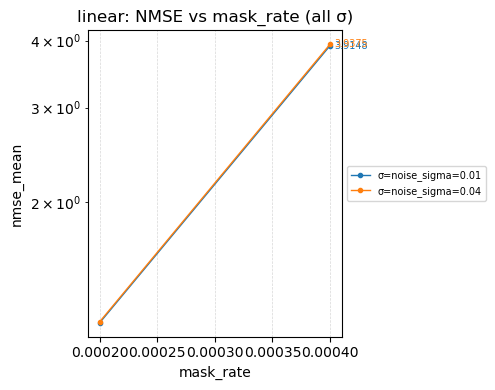

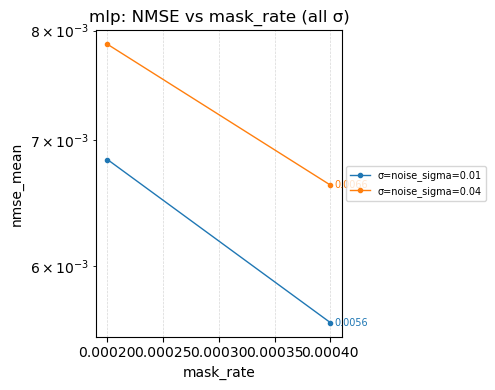

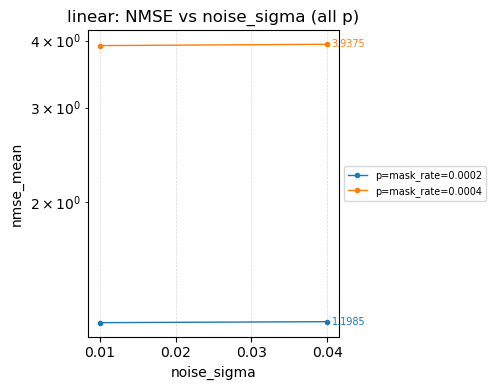

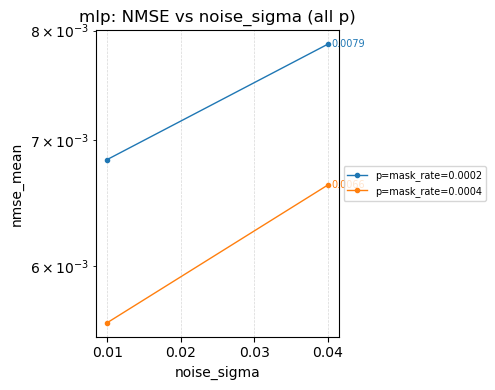

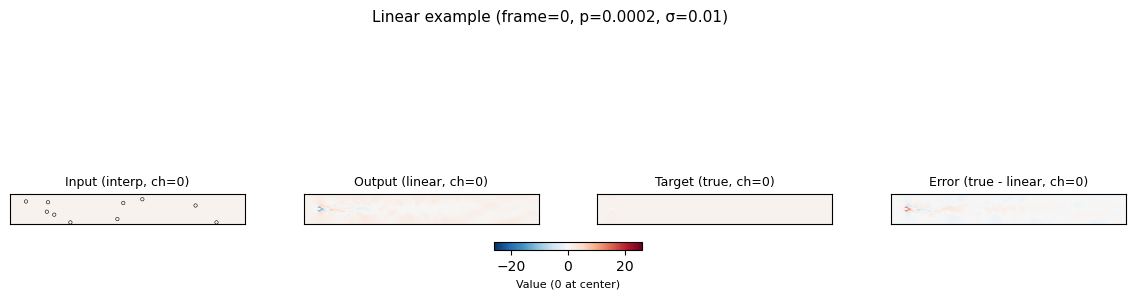

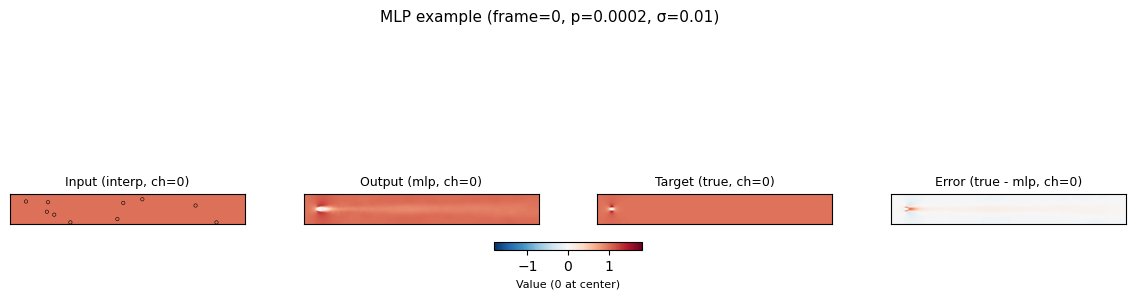

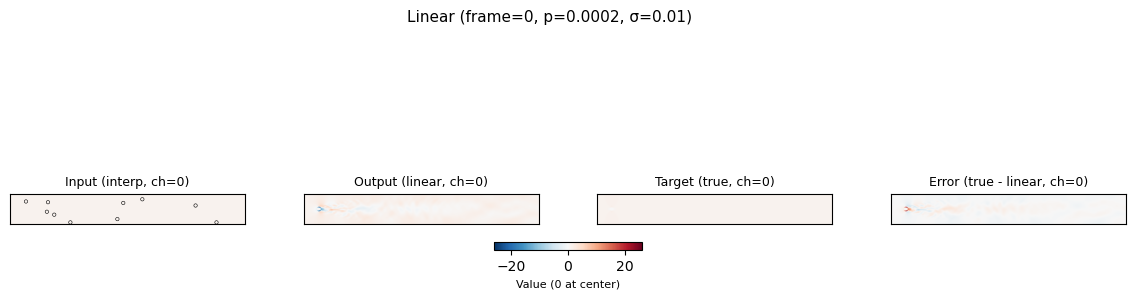

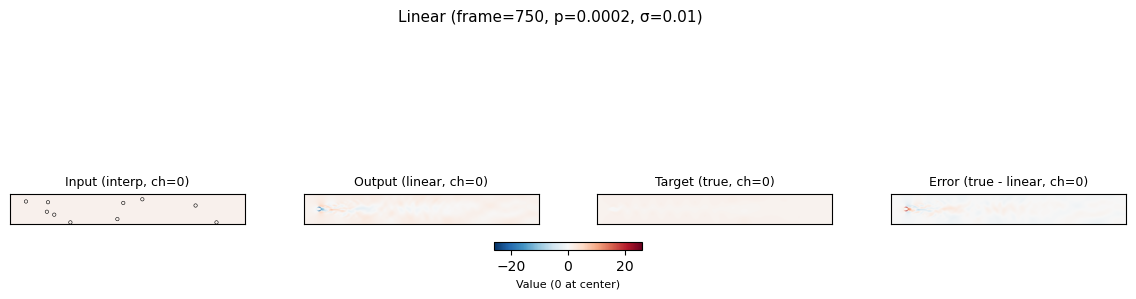

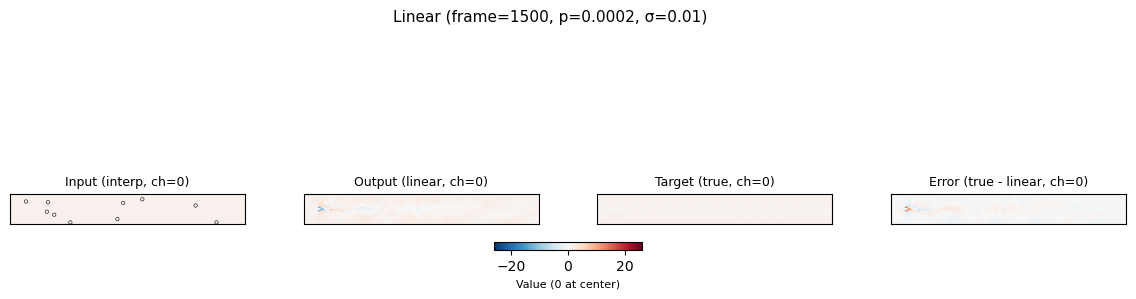

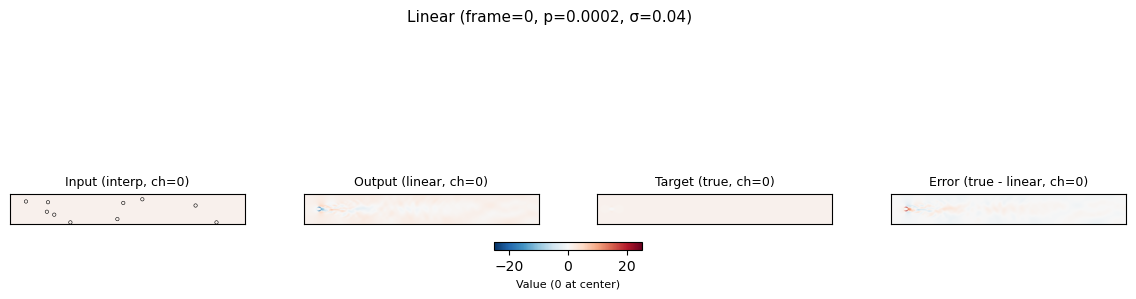

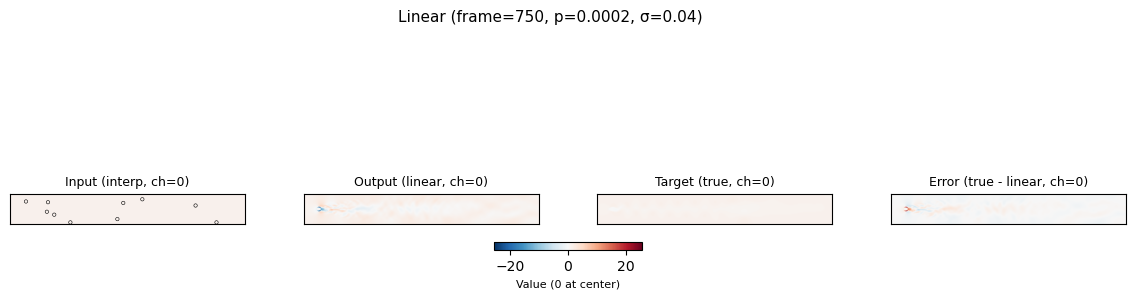

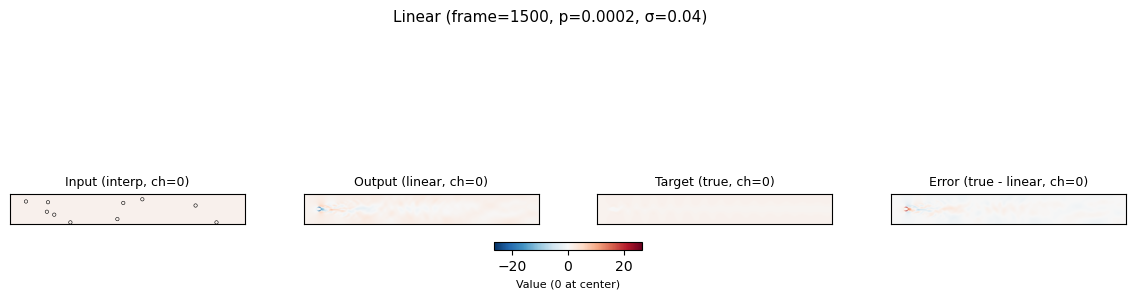

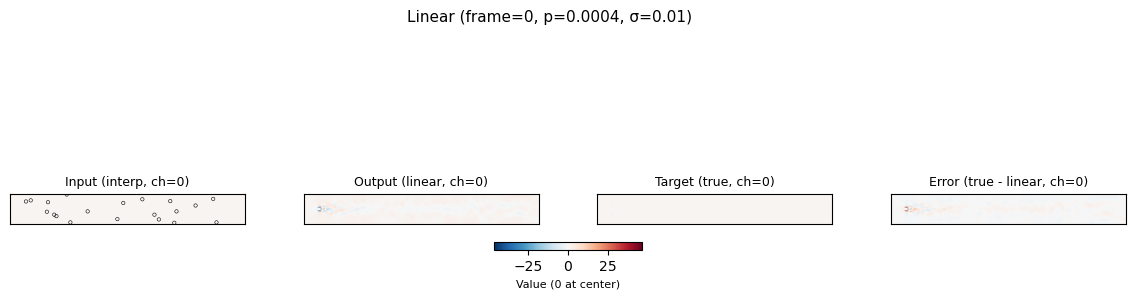

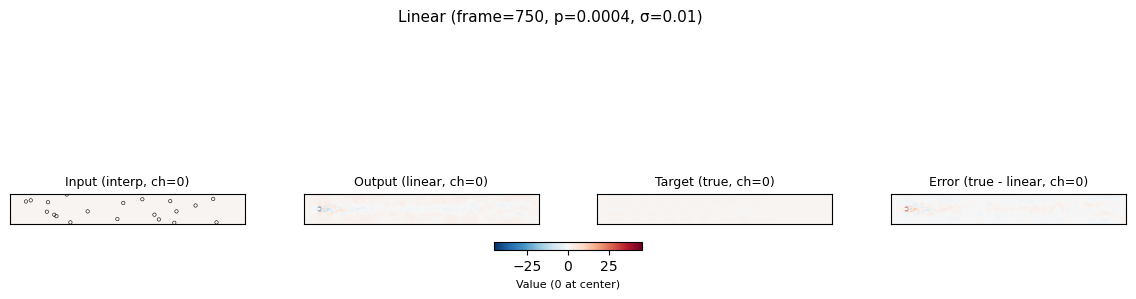

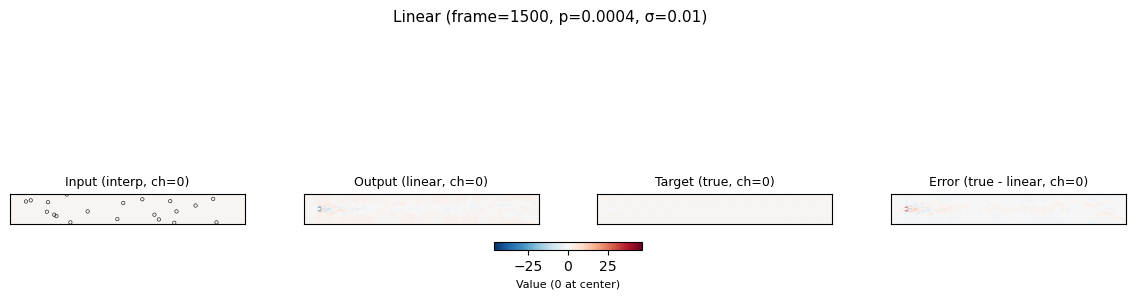

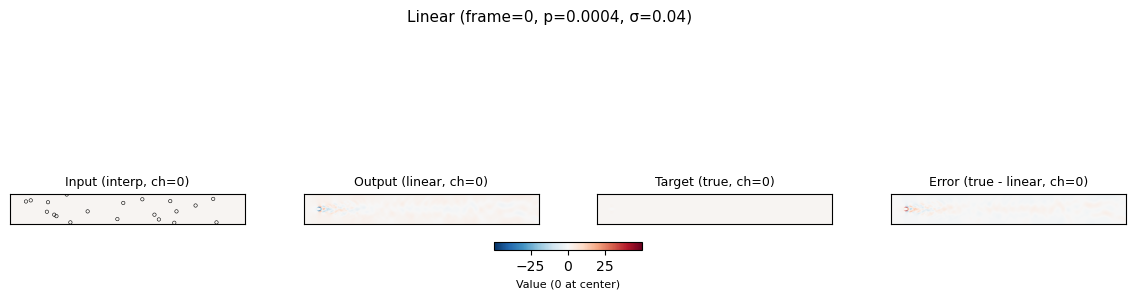

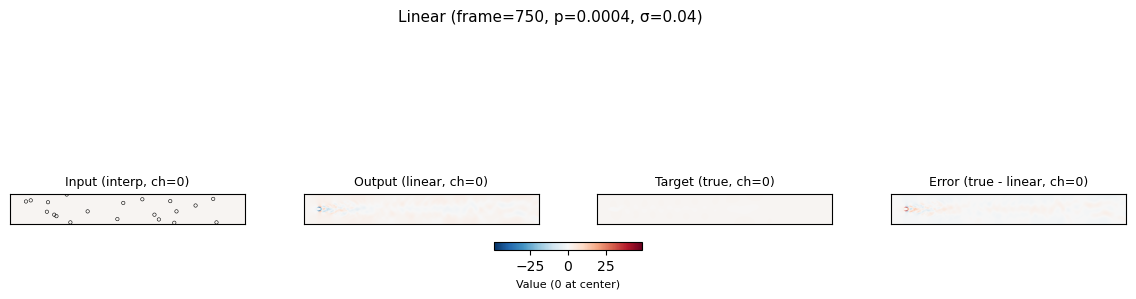

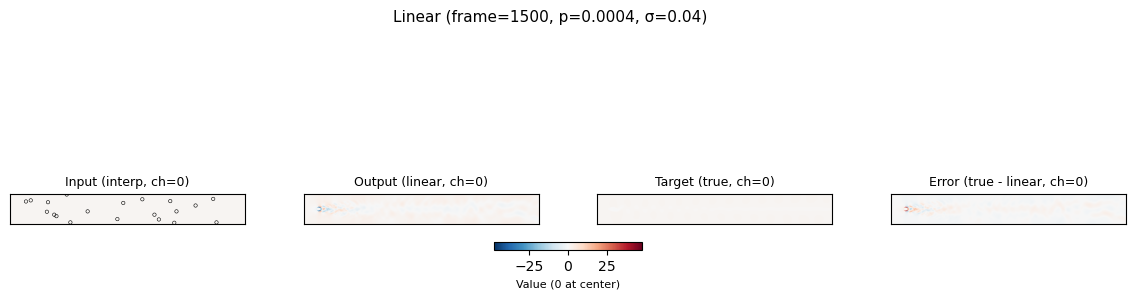

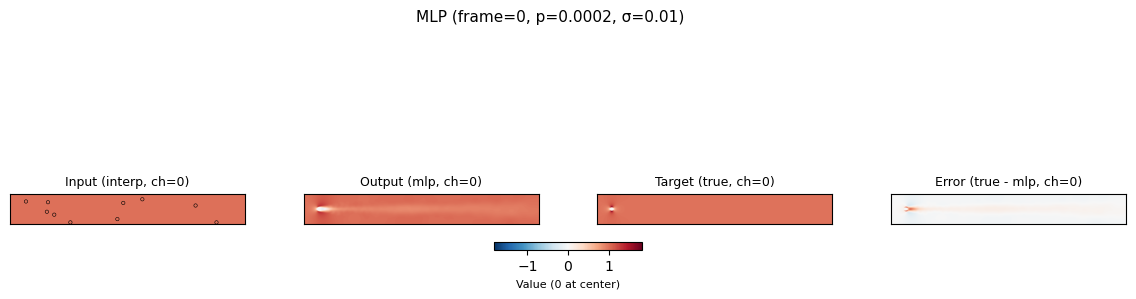

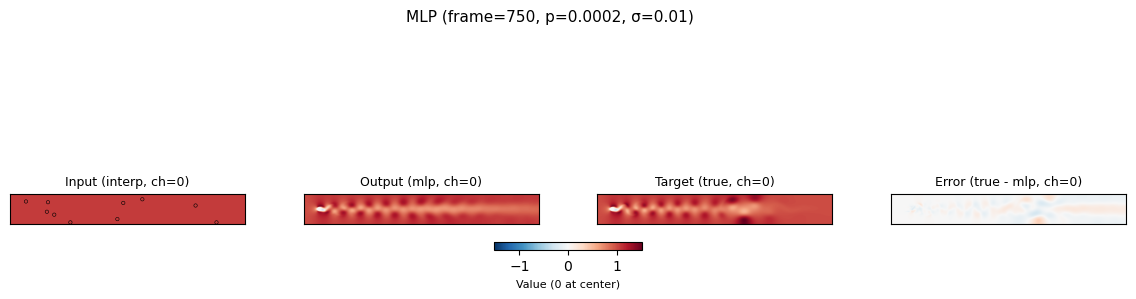

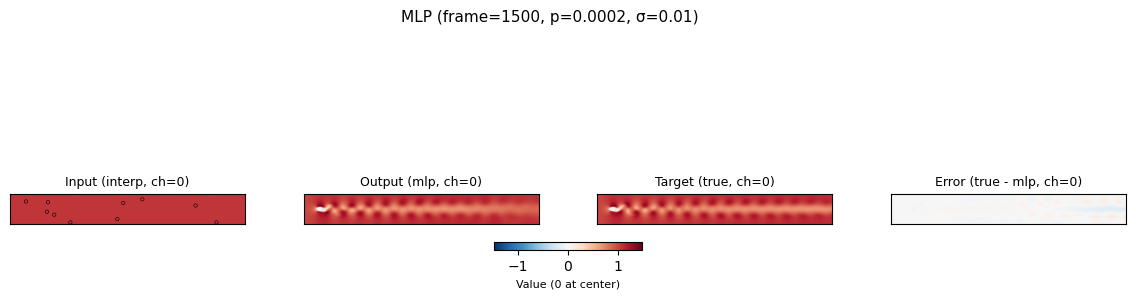

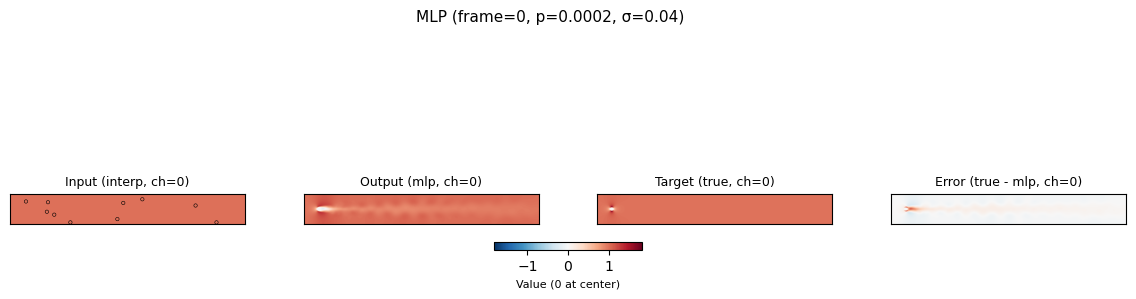

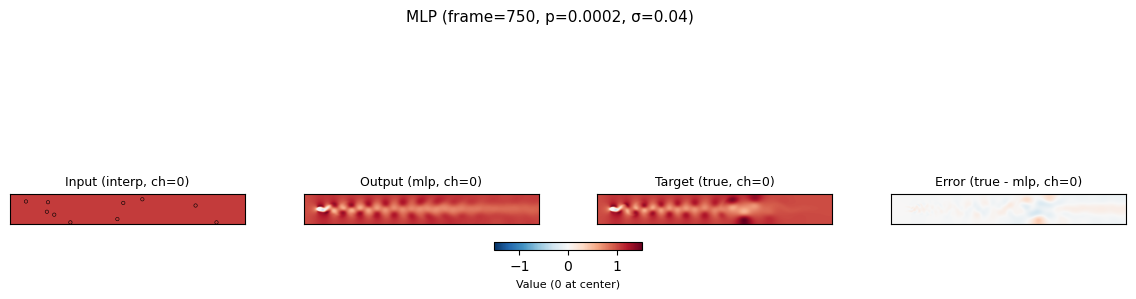

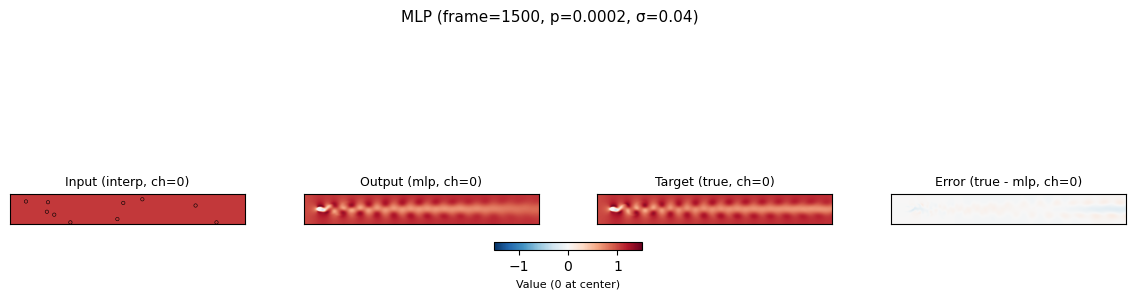

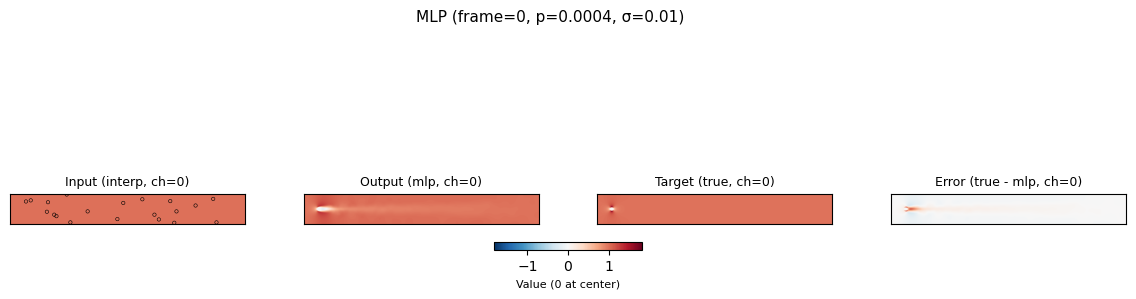

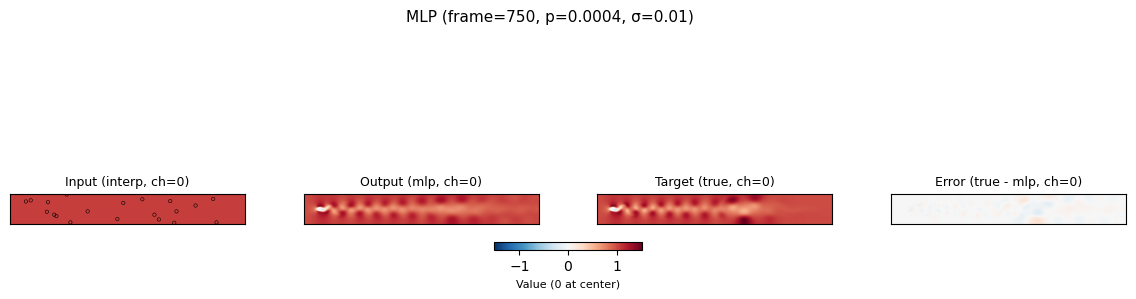

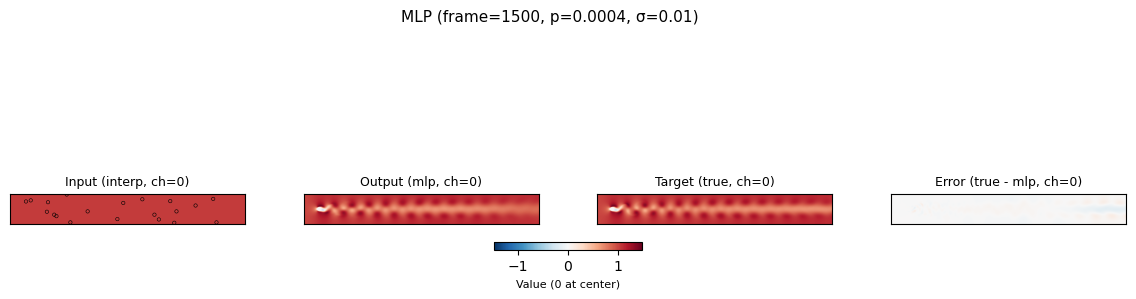

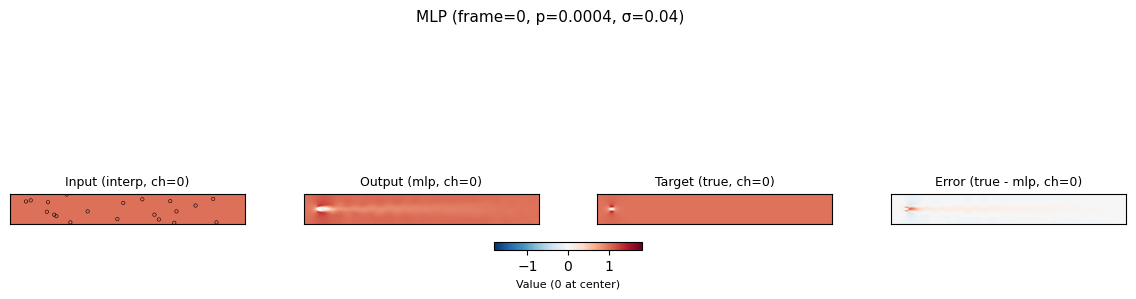

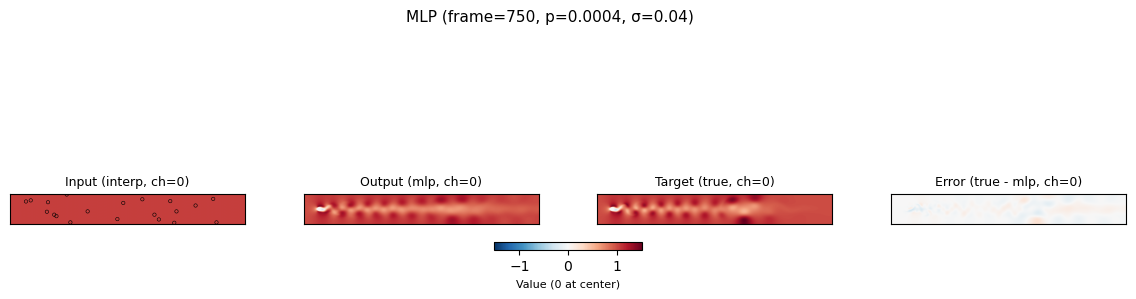

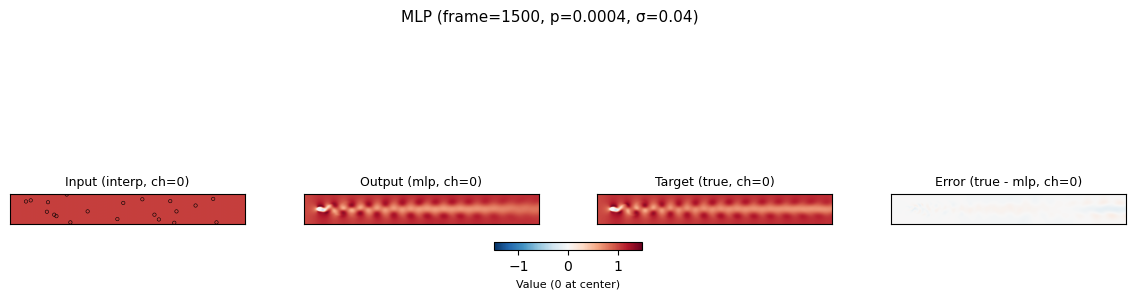

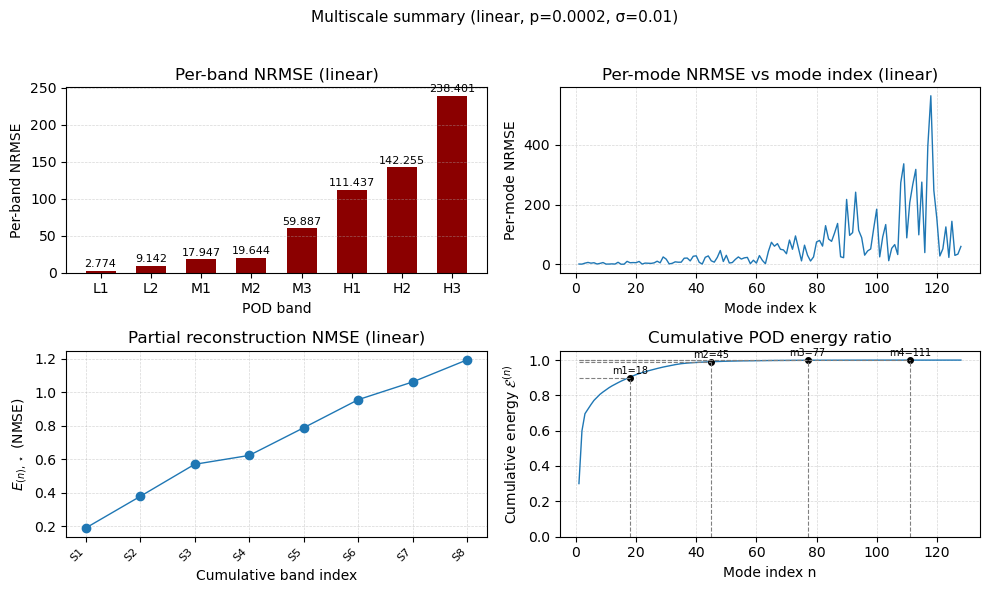

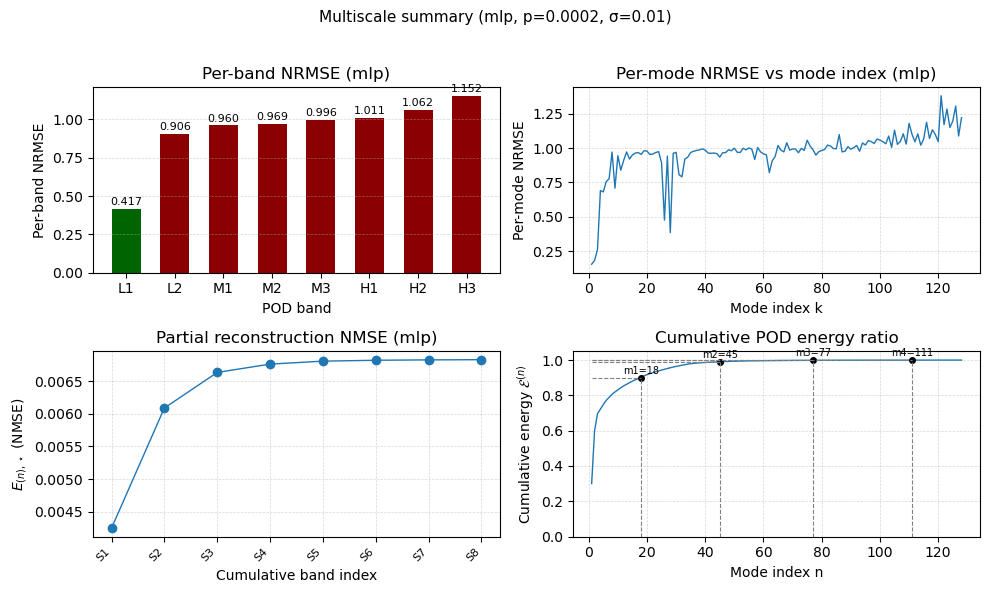

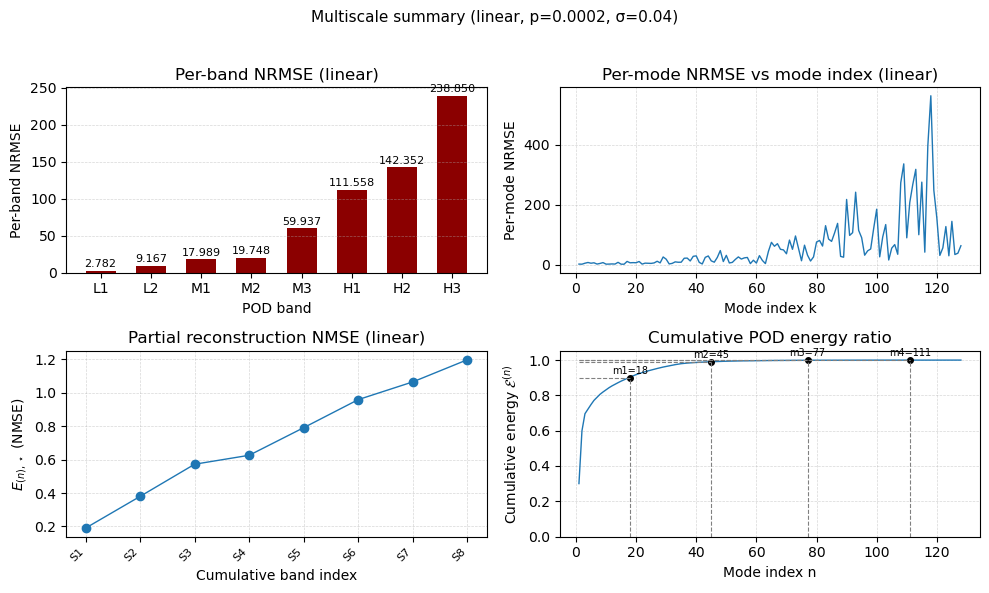

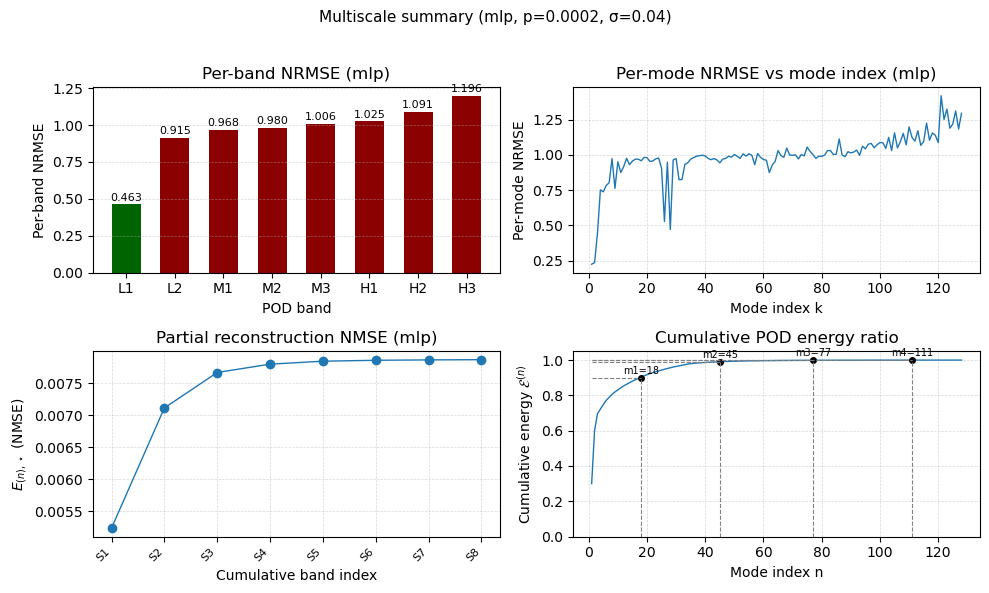

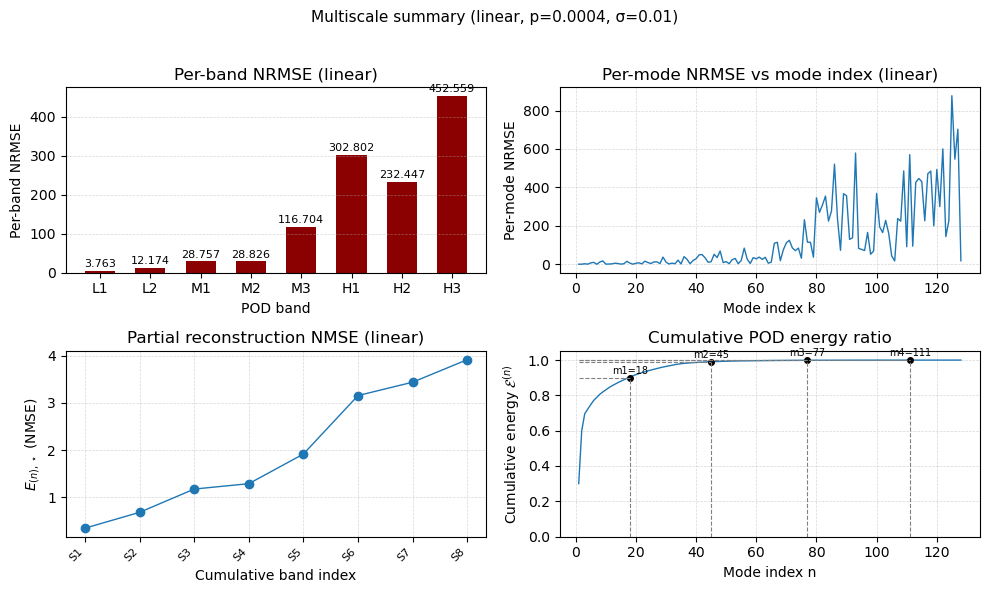

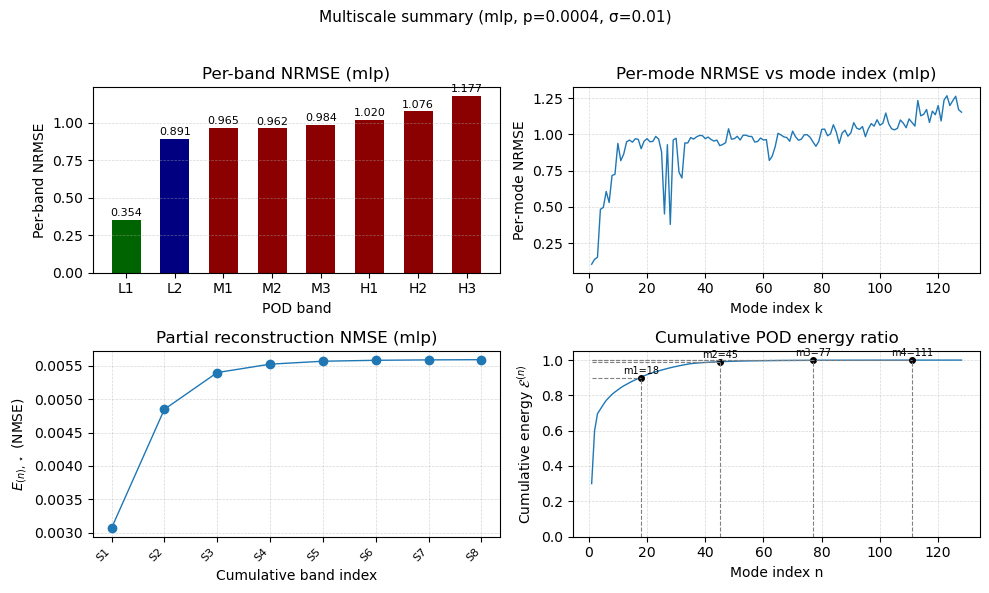

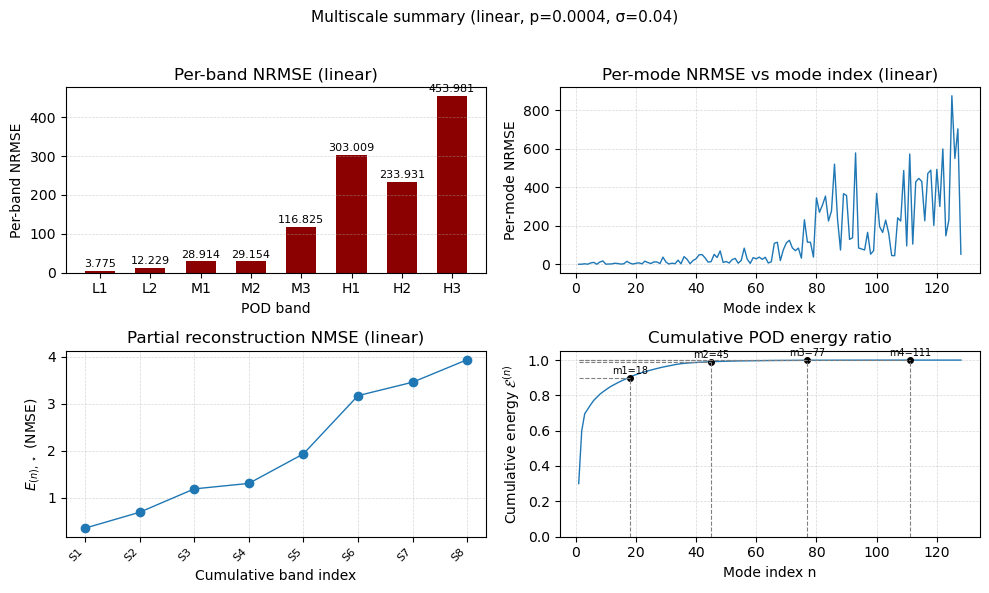

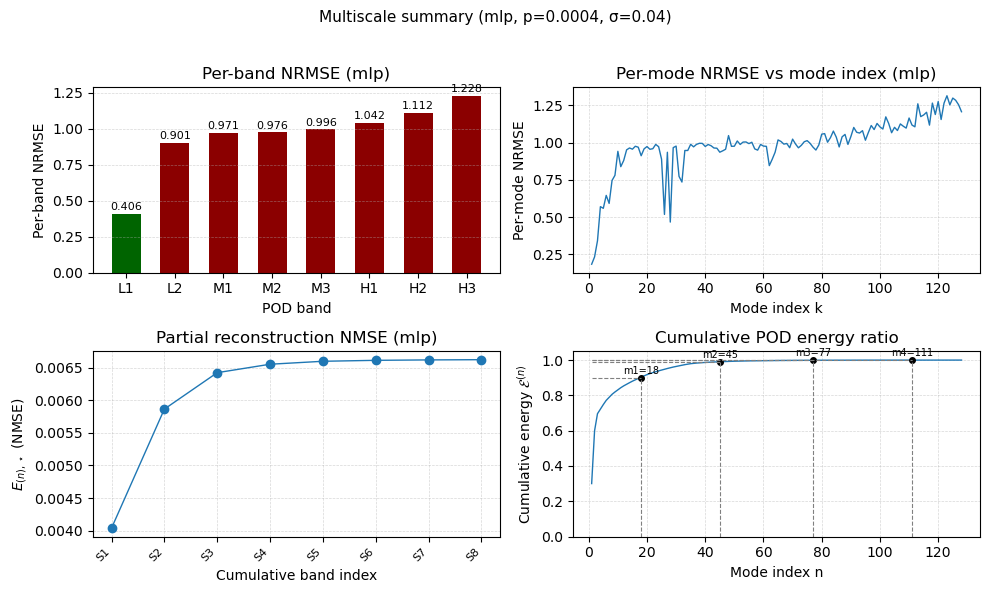

In [1]:
from backend.pipeline import run_experiment_from_yaml

res = run_experiment_from_yaml(
    "configs/cylinder_exp1.yaml",
    experiment_name="cylinder_exp1_3",
    save_root="artifacts/experiments",
    generate_report=True,
    verbose=True,
)

print("报告路径:", res["report_path"])
res["df_linear"].head()


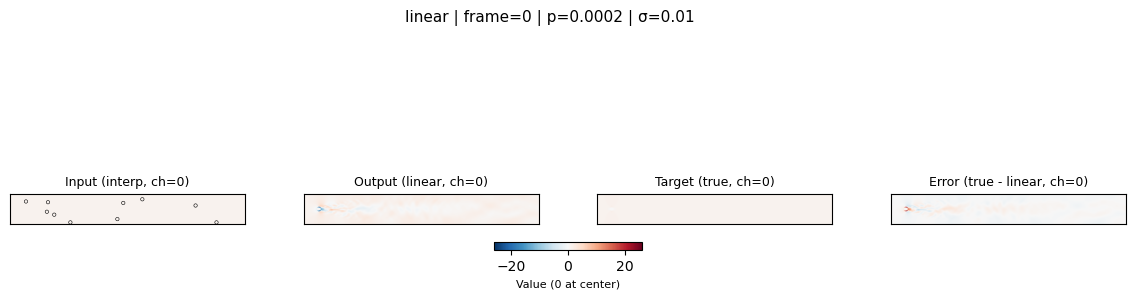

In [2]:
from backend.pipeline import plot_example_from_npz

fig = plot_example_from_npz(
    "artifacts/experiments/cylinder_exp1_3/p0-0002_sigma0-01/linear_example_00.npz",
    channel=0,
)

[quick-figs] Loading numeric results from artifacts/experiments/cylinder_exp1_3 ...
[build-figs] inferred columns from linear df: mask=mask_rate, noise=noise_sigma, nmse=nmse_mean
[quick-figs] Figures rebuilt from saved numeric results.


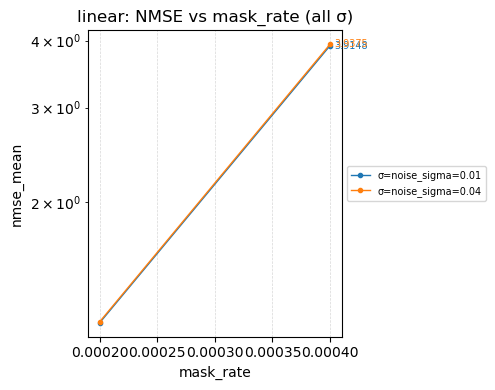

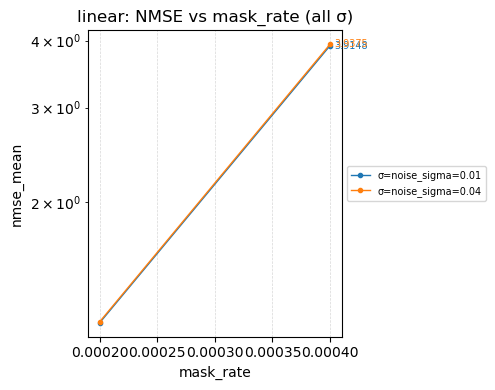

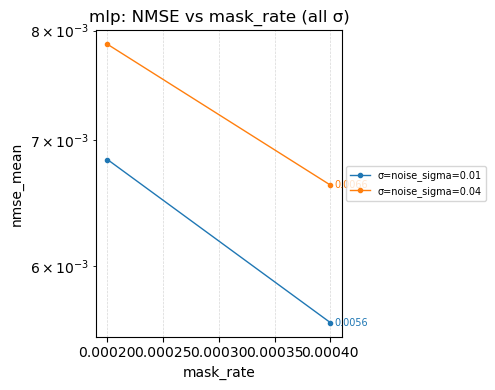

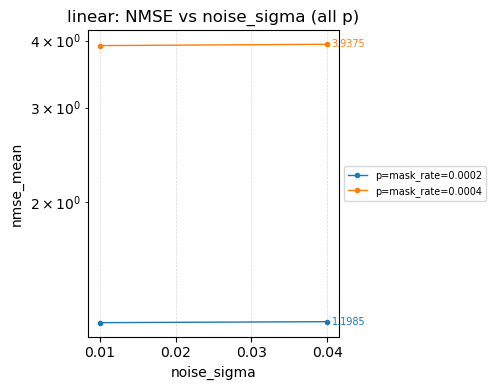

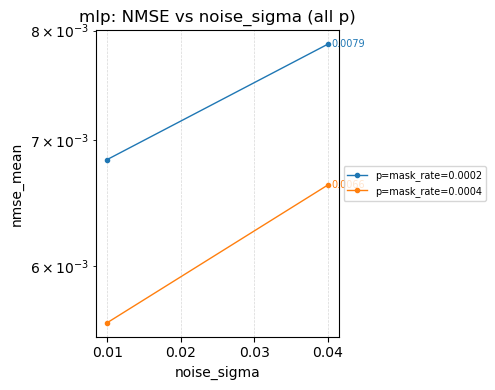

In [3]:
from backend.pipeline import quick_figs_from_saved_experiment

figs = quick_figs_from_saved_experiment("artifacts/experiments", "cylinder_exp1_3")
figs["fig_nmse_vs_mask_linear"]
